### Experiment 1 - Generate sequences at variable % identity,  evaluate Sourmash similarities

This notebook is modified from the original experiment-1 version to deal with proteins!

Note: one clear observation comparing NR to NT is that the protein lengths are much smaller than the typical sequence length in NT. This has an impact on the desired `scaled` parameter value because we're seeing that for short sequences, haveing `scaled = 100 or 1000` is producing extremely wide distributions of sourmash distance.

It seems that for short sequences, `scaled = 10` works best.

This paper: https://www.biorxiv.org/content/10.1101/2021.12.03.470944v1.full.pdf investigates the distribution of protein sequences across various organisms. The averages are typically ~200aa. 

When sequence length = 50 we actually have sourmash dist = 0 for all sequences (using k =31)

In [49]:
from Bio import SeqIO
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [50]:
#! grep ">" GCF_900618125.1_NCTC11032_genomic.fna

In [51]:
# read the original NCBI reference sequence

#filename = "../refs/rhinovirus_YP_001552411.1.fasta" 
#filename = "../refs/streptococcus_VDG79570_102aa.fasta"
filename = "../refs/streptococcus_VDG79582_PBP_731aa.fasta"
#filename = "../refs/streptococcus_VDG79577_shortened_50aa.fasta"

original_record = SeqIO.read(filename, "fasta") # NOTE: this only works with single-sequence .fasta files

id_thresholds = [0.99, 0.97, 0.95, 0.92, 0.9, 0.85, 0.8]  # specified list of thresholds

def mutate_sequence(sequence, pid):
    '''
    Given a sequence and a % ID threshold, mutate the sequence at random positions to produce
    a new sequence with the specified % ID. Return the new sequence string.
    '''
    
    swap_values = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 
                             'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] # amino acid characters
    
    len_of_seq = len(sequence)
    num_bp_to_change = (np.round(len_of_seq) * (1-pid))
    all_bp_locs = [b for b in range(len_of_seq)]    
    bp_locs_to_change = random.sample(all_bp_locs, int(num_bp_to_change))
    
    # loop through indices of bases to change and swap out values
    new_seq = list(sequence)
    for bp in bp_locs_to_change:
        new_seq[bp] = random.sample([i for i in swap_values if i != new_seq[bp] ], 1)[0]
        
    return("".join(new_seq))

# currate a dictionary of mutated sequences at specified %ID thresholds
sequence_dict = {original_record.id : original_record.seq}
for i in id_thresholds:
    for j in range(10):
        this_seq = mutate_sequence(original_record.seq, i)
        sequence_dict[str(i) + '-' + str(j+1)] = this_seq
        
# write the mutated sequences to a fasta file
with open("all_simulated_seqs.fasta", 'w') as f: 
    for s in sequence_dict:
        f.write('>' + s + '\n' + str(sequence_dict[s]) + '\n')
f.close()


== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: all_simulated_seqs.fasta
Computing a total of 1 signature(s) for each input.
calculated 71 signatures for 71 sequences in all_simulated_seqs.fasta
saved 71 signature(s) to 'all_simulated_seqs.fasta.sig'. Note: signature license is CC0.

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 71 signatures total.                                                    

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 71 signatures total.                                                    

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist

== This is sourmash version 4.6.

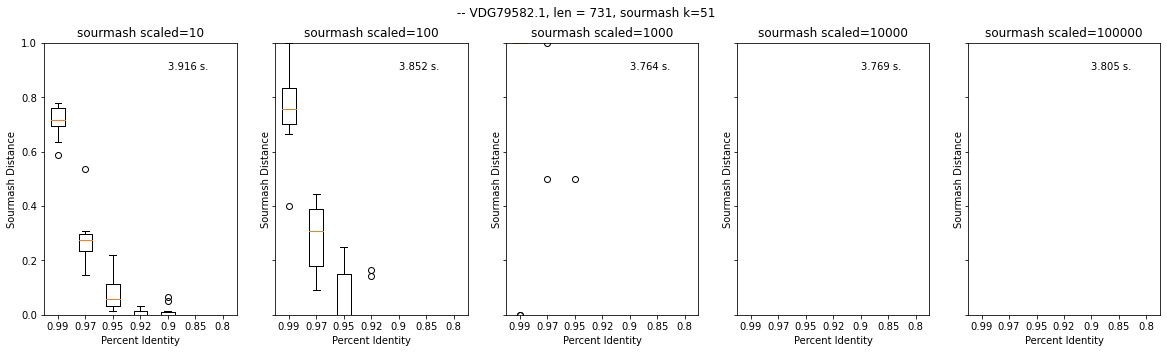

In [52]:
# Iteratively run sourmash at varying *scaled* parameters...
# and plot the sourmash distances as a function of the known percent identity

#%%capture
K = 31 #21, 31, 51
    
fig, axs = plt.subplots(1, 5, sharey='row', sharex='col', figsize=(20,5))
fig.suptitle(filename.split('.')[0] + ' -- ' + original_record.id + 
          ', len = ' + str(len(original_record.seq)) + ', sourmash k=' + str(K) + '\n\n\n')

scale_thresholds = [10, 100, 1000, 10000, 100000]

for scale_threshold_id in range(len(scale_thresholds)):
    
    ST = scale_thresholds[scale_threshold_id]
    
    start = time.time()
    
    ! rm cmp*;
    ! rm *sig;
    # num was scaled
    ! sourmash sketch protein -p k={K},scaled={ST} --singleton all_simulated_seqs.fasta;
    ! sourmash compare *.sig --containment -o cmp.dist;
    ! sourmash compare *.sig --containment -o cmp.dist --csv cmp.csv;

    end = time.time()
    elapsed = end - start
    
    df = pd.read_csv("cmp.csv")
    df.index = df.columns
    
    combined_dict = {}
    for i in id_thresholds:
        indexes = [j for j in df.index if str(i) == str(j.split('-')[0])]
        combined_dict[i] = list(df.iloc[0][indexes])
        
    labels, data = [*zip(*combined_dict.items())]  # 'transpose' items to parallel key, value lists
    # or backwards compatable    
    labels, data = combined_dict.keys(), combined_dict.values()
    
    axs[scale_threshold_id].boxplot(data, labels = labels)
    axs[scale_threshold_id].set_ylim(0,1)
    axs[scale_threshold_id].set_ylabel("Sourmash Distance")
    axs[scale_threshold_id].set_xlabel("Percent Identity")
    axs[scale_threshold_id].set_title('sourmash scaled=' + str(ST))
    axs[scale_threshold_id].text(5, .9, str(np.round(elapsed, 3)) + ' s.')

plt.show()

### Exp 1B. What happens when sequences are sub-sequences of the original dataset?

Let's say, we settle on scaled = 1000 and k = 31. 
What happens when we have varying sizes of input sequences?

In [53]:
# read the original NCBI reference sequence

#filename = "../refs/rhinovirus_YP_001552411.1.fasta"
#filename = "../refs/streptococcus_VDG79570_102aa.fasta"
filename = "../refs/streptococcus_VDG79582_PBP_731aa.fasta"
#filename = "../refs/streptococcus_VDG79577_shortened_50aa.fasta"


original_record = SeqIO.read(filename, "fasta") # NOTE: this only works with single-sequence .fasta files

id_thresholds = [0.99, 0.97, 0.95, 0.92, 0.9, 0.85, 0.8]  # specified list of thresholds


1

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: all_simulated_seqs.fasta
Computing a total of 1 signature(s) for each input.
calculated 176 signatures for 176 sequences in all_simulated_seqs.fasta
saved 176 signature(s) to 'all_simulated_seqs.fasta.sig'. Note: signature license is CC0.

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 176 signatures total.                                                   

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 176 signatures total.                                                   

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist
            VDG79582.1    0.


== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: all_simulated_seqs.fasta
Computing a total of 1 signature(s) for each input.
calculated 176 signatures for 176 sequences in all_simulated_seqs.fasta
saved 176 signature(s) to 'all_simulated_seqs.fasta.sig'. Note: signature license is CC0.

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 176 signatures total.                                                   

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist

== This is sourmash version 4.6.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 176 signatures total.                                                   

min similarity in matrix: 0.000
saving labels to: cmp.dist.labels.txt
saving comparison matrix to: cmp.dist
            VDG79582.1  0.99-1

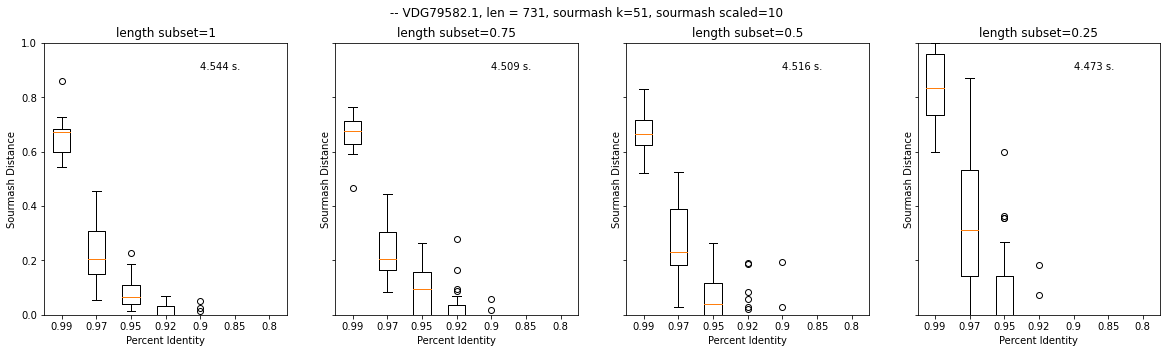

In [54]:
# Iteratively run sourmash at varying *scaled* parameters...
# and plot the sourmash distances as a function of the known percent identity

#%%capture
K = 31 #51 #21 #31
ST = 10 # 100
    
fig, axs = plt.subplots(1, 4, sharey='row', sharex='col', figsize=(20,5))
fig.suptitle(filename.split('.')[0] + ' -- ' + original_record.id + 
          ', len = ' + str(len(original_record.seq)) + ', sourmash k=' + str(K) + 
             ', sourmash scaled=' + str(ST) + '\n\n\n')

length_thresholds = [1, 0.75, 0.5, 0.25]

for length_threshold_id in range(len(length_thresholds)):
    
    LT = length_thresholds[length_threshold_id]
    print(LT)
    
    # currate a dictionary of mutated sequences at specified %ID thresholds
    sequence_dict = {original_record.id : original_record.seq}
    for i in id_thresholds:
        for j in range(25):
            # experiment 1B approach
            #this_seq = mutate_sequence(original_record.seq, i)
            #this_sub_seq = this_seq[0:int(np.floor(LT * len(this_seq)))]
            
            #experiment 1C approach
            this_seq = mutate_sequence(original_record.seq[0:int(np.floor(LT * len(original_record.seq)))], i)
            this_sub_seq = this_seq
            
            sequence_dict[str(i) + '-' + str(j+1)] = this_sub_seq

    # write the mutated sequences to a fasta file
    with open("all_simulated_seqs.fasta", 'w') as f: 
        for s in sequence_dict:
            f.write('>' + s + '\n' + str(sequence_dict[s]) + '\n')
    f.close()
    
    
    start = time.time()
    
    
    '''
    The containment matrix is organized such that the value in row A for column B is the containment 
    of the B’th sketch in the A’th sketch, i.e. C(A, B) = B.contained_by(A)
    
    SO, we want the top row of the csv...
    ... which will show to what extent each modified seq is contained in the original seq. 
    We are doing this, confirmed by visual inspection of dataframe with the combined_dict values
    '''
    
    ! rm cmp*;
    ! rm *sig;
    ! sourmash sketch protein -p k={K},scaled={ST} --singleton all_simulated_seqs.fasta;
    ! sourmash compare *.sig --containment -o cmp.dist;
    ! sourmash compare *.sig --containment -o cmp.dist --csv cmp.csv;

    end = time.time()
    elapsed = end - start
    
    df = pd.read_csv("cmp.csv")
    df.index = df.columns
    print(df.head())
     
    combined_dict = {}
    for i in id_thresholds:
        indexes = [j for j in df.index if str(i) == str(j.split('-')[0])]
        combined_dict[i] = list(df.iloc[0][indexes])
        
    print(combined_dict)

    labels, data = [*zip(*combined_dict.items())]  # 'transpose' items to parallel key, value lists
    # or backwards compatable    
    labels, data = combined_dict.keys(), combined_dict.values()
    
    axs[length_threshold_id].boxplot(data, labels = labels)
    axs[length_threshold_id].set_ylim(0,1)
    axs[length_threshold_id].set_ylabel("Sourmash Distance")
    axs[length_threshold_id].set_xlabel("Percent Identity")
    axs[length_threshold_id].set_title('length subset=' + str(LT))
    axs[length_threshold_id].text(5, .9, str(np.round(elapsed, 3)) + ' s.')

plt.show()